In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from hembedder.utils import distance, hyperparameter_tuning, quality_metrics


import umap
from umap.parametric_umap import ParametricUMAP
import phate
import ivis
import pacmap

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, OPTICS

import gc

In [2]:
os.chdir('T:/laupodteam/AIOS/Bram/data')

# Load data

This is imputed CELLDYN with combined variables.

In [3]:
celldyn_raw = pd.read_feather("./CellDyn/celldyn.feather")
celldyn_raw.columns = celldyn_raw.columns.str.lower()
fail_columns = [c for c in celldyn_raw.columns if 'fail' in c]
celldyn_raw = celldyn_raw.query('c_b_ht>0.2 and c_b_hb>0.2 and c_b_rbco>0.1 and c_b_rbco<100 and c_b_hb<20')
meas_columns_raw = [c for c in celldyn_raw.columns if 'c_b' in c]+['plt']
celldyn_raw['fcs_id'] = celldyn_raw['fcs_id'].str.decode('utf-8')
celldyn_raw = celldyn_raw.dropna(subset=meas_columns_raw)

In [4]:
celldyn_full = pd.read_feather("L:/laupodteam/AIOS/Bram/data/CellDyn/artifacts/celldyn_FULL_transformed_df.feather")
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c or 'COMBO_' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]
demo_columns = ['gender', 'age']

In [5]:
celldyn_full_updated = pd.read_feather("./CellDyn/artifacts/celldyn_FULL_transformed_df_updated.feather")
replace_combos = {c: "COMBO_"+c for c in ['SII', 'NHL', 'NLR', 'PLR', 'HLR', 'LMR', 'WRR', 
                             'NWR', 'WPR', 'PRR', 'RHR', 'RIR', 'HHR',  'LSR',
                              'PMR', 'LPR', 'MHR', 'MMR']}
celldyn_full_updated = celldyn_full_updated.rename(columns=replace_combos)
meas_columns_update = [c for c in celldyn_full_updated.columns if 'c_b' in c or 'COMBO_' in c]

In [6]:
meta = pd.read_parquet("./CellDyn/artifacts/celldyn_labels.parquet")
meta = meta[~meta.dataset.isnull()]
meta = meta.rename(columns={'studyId_Alle_celldyn': 'studyid_alle_celldyn'})

In [7]:
meta = meta.assign(INFLAM=meta['dataset'].str.contains('MDL|REUMA'))
meta = meta.assign(HEART=meta['dataset'].str.contains('ARGUS|UCORBIO|HEARTSCORE'))
meta = meta.assign(BLOOD=meta['dataset'].str.contains('MDS|CLL'))
CCOLS=['INFLAM', 'HEART', 'BLOOD']

In [8]:
# append celldyn indices
celldyn_raw = celldyn_raw.merge(meta[['fcs_id', 'dataset']+CCOLS], on='fcs_id', how='left')
celldyn_full = celldyn_full.merge(meta[['studyid_alle_celldyn', 'afname_dt', 'dataset']+CCOLS],
                                   on=['studyid_alle_celldyn', 'afname_dt'], how='left')
celldyn_full_updated = celldyn_full_updated.merge(meta[['studyid_alle_celldyn', 'afname_dt', 'dataset']+CCOLS],
                                   on=['studyid_alle_celldyn', 'afname_dt'], how='left')

## Reduce dimensions

In [9]:
from keras import backend as K
from keras import Input, Model, Sequential
from keras.layers import Conv1D, Conv1DTranspose, AveragePooling1D, MaxPooling1D
from keras.layers import Dense, Flatten, Reshape, Dropout, BatchNormalization
from keras.layers import Activation, LeakyReLU, ReLU, Concatenate, Dropout, UpSampling1D

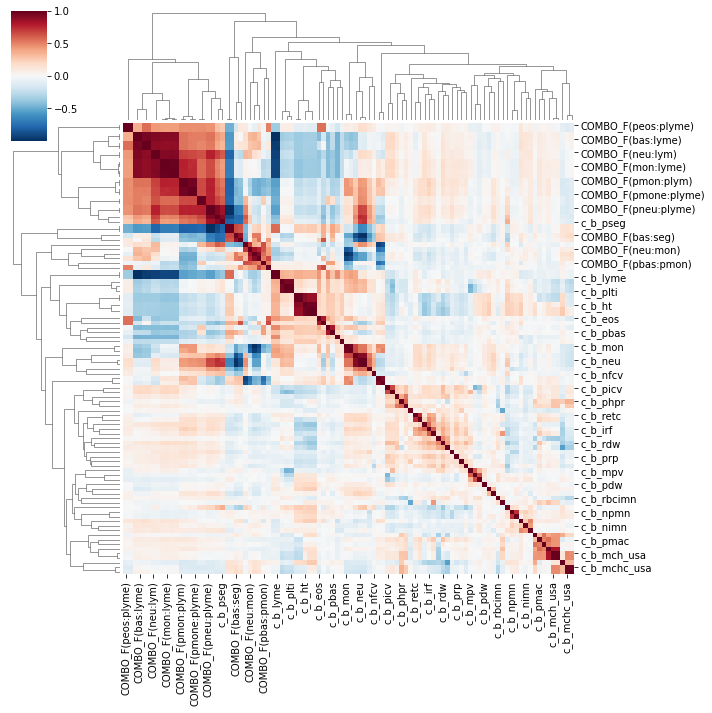

In [10]:
#celldyn_full_updated[meas_columns_update].median().hist(bins=25)
corr_matrix = celldyn_full.sample(50000)[meas_columns].corr(method='spearman')
sns.clustermap(corr_matrix, cmap='RdBu_r', center=0, figsize=(10,10))

In [11]:
# encoder block using 1D convolution layers

def make_coders(arch: str='arch1', latent_dim: int=2, input_dim: int=100, layers: list=[256,128,128,64,64]):
    if arch == 'arch1':
        encoder = Sequential([
            Input(shape=(input_dim, 1)),
            Conv1D(filters=64, kernel_size=3, strides=2, padding='same'),
            LeakyReLU(),
            Conv1D(filters=32, kernel_size=3, strides=2, padding='same'),
            LeakyReLU(),
            Conv1D(filters=64, kernel_size=3, strides=2, padding='same'),
            Flatten(),
            Dense(32, activation='relu'),
            Dense(latent_dim, activation='linear')
        ])
        dim_after_maxpool = input_dim // (2**3)  # 3 max-pooling layers with pool_size=2
        decoder = Sequential([
            Input(shape=(latent_dim,)),
            Dense(32, activation='relu'),
            Dense(64 * dim_after_maxpool, activation='relu'),
            Reshape((dim_after_maxpool, 64)),
            Conv1DTranspose(filters=64, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(),
            Conv1DTranspose(filters=32, kernel_size=4, strides=2, padding='same'),
            LeakyReLU(),
            Conv1DTranspose(filters=64, kernel_size=4, strides=2, padding='same'),
            Conv1D(filters=1, kernel_size=3, strides=1, padding='same', activation='linear')
        ])
    elif arch == 'arch2':
        # encoder/decoder with dense layers
        encoder = Sequential([
                Input(shape=(input_dim, 1)),
                Flatten()]  +
                [Dense(l, activation='relu') for l in layers]+
                [
                    Dense(latent_dim, activation='linear')
                ])
        decoder = Sequential([
                Input(shape=(latent_dim,))]+
                [Dense(l, activation='relu') for l in reversed(layers)]+
                [
                    Dense(
                        units=input_dim, name="recon", activation=None
                    ),
                    Reshape((input_dim,1)),
                ])

    return encoder, decoder

In [33]:
SAMPLE_SIZE = 400
embedder_type = 'umap'
n_dims = 3
n_input_dimensions = 80 # uses PCA to reduce dimensionality
arch = 'arch2'
write_to_disk = False
read_from_disk = True
supervised=True
global_loss_weight=0.1 # between 0 and 1, 0 purely local, 1 is basically non-linear PCA

In [13]:
if read_from_disk:
    celldyn_raw = pd.read_parquet("./CellDyn/artifacts/celldyn_raw_with_pca.parquet")
    celldyn_full = pd.read_parquet("./CellDyn/artifacts/celldyn_full_with_pca.parquet")
    celldyn_full_updated = pd.read_parquet("./CellDyn/artifacts/celldyn_full_updated_with_pca.parquet")
else:
    pca_celldyn_raw = PCA(n_components=n_input_dimensions)\
                                        .fit_transform(celldyn_raw[meas_columns_raw])
    pca_celldyn_full = PCA(n_components=n_input_dimensions)\
                                        .fit_transform(celldyn_full[meas_columns])
    pca_celldyn_full_updated = PCA(n_components=n_input_dimensions)\
                                        .fit_transform(celldyn_full_updated[meas_columns_update])

    gc.collect()

    PCA_cols = ['pca_{}'.format(i) for i in range(n_input_dimensions)]
    celldyn_raw.loc[:, PCA_cols] = pca_celldyn_raw
    celldyn_full.loc[:, PCA_cols] = pca_celldyn_full
    celldyn_full_updated.loc[:, PCA_cols] = pca_celldyn_full_updated

    del pca_celldyn_raw, pca_celldyn_full, pca_celldyn_full_updated
    gc.collect()

    if write_to_disk:
        celldyn_raw.to_parquet("./CellDyn/artifacts/celldyn_raw_with_pca.parquet")
        celldyn_full.to_parquet("./CellDyn/artifacts/celldyn_full_with_pca.parquet")
        celldyn_full_updated.to_parquet("./CellDyn/artifacts/celldyn_full_updated_with_pca.parquet")
        PCA_cols = [c for c in celldyn_raw.columns if c.startswith('pca_')]
        gc.collect()

In [45]:
# CNN13 network as AE for SSL

if embedder_type == 'umap':
    kwargs =   {'n_neighbors': 150, 
                'min_dist': 0., 
                'n_components': n_dims, 
                'random_state': 42, 
                'n_epochs': 200,
                'metric': 'canberra', # canberra, manhattan
                'output_metric': 'euclidean', 
                'init': 'random',
                'learning_rate': 0.9,
                'repulsion_strength': 1.1,
                'negative_sample_rate': 20,
                'densmap': True,
                'verbose': True}

    embedder_raw = umap.UMAP(**kwargs)
    embedder_full = umap.UMAP(**kwargs)
    embedder_full_update = umap.UMAP(**kwargs)
elif embedder_type == 'parametric_umap':
    kwargs =   {
                'parametric_reconstruction': True,
                'batch_size': 256, 
                'n_training_epochs': 1,
                'autoencoder_loss': True,    
                'verbose': True,
                'optimizer': 'adam',
                'n_components': n_dims,
                'global_correlation_loss_weight': global_loss_weight
                }
    
    if arch is not None:
        encoder, decoder = make_coders(arch=arch, latent_dim=n_dims,  input_dim=n_input_dimensions)
        kwargs['encoder'] = encoder
        kwargs['decoder'] = decoder
    # add a random sample of the data to validate the reconstruction
    # using numpy on pca_celldyn_raw to avoid memory issues
    kwargs['reconstruction_validation'] =  MinMaxScaler().fit_transform(celldyn_raw.sample(1000)[PCA_cols])
    embedder_raw = ParametricUMAP(**kwargs)

    encoder, decoder = make_coders(arch=arch, latent_dim=n_dims,  input_dim=n_input_dimensions)
    kwargs['encoder'] = encoder
    kwargs['decoder'] = decoder
    kwargs['reconstruction_validation'] = MinMaxScaler().fit_transform(celldyn_full.sample(1000)[PCA_cols])
    embedder_full = ParametricUMAP(**kwargs)

    encoder, decoder = make_coders(arch=arch, latent_dim=n_dims,  input_dim=n_input_dimensions)
    kwargs['encoder'] = encoder
    kwargs['decoder'] = decoder
    kwargs['reconstruction_validation'] = MinMaxScaler().fit_transform(celldyn_full_updated.sample(1000)[PCA_cols]) 
    embedder_full_update = ParametricUMAP(**kwargs)    
elif embedder_type == 'phate':
    embedder_raw = phate.PHATE(knn=50, t=100, n_jobs=-1, n_components=n_dims, random_state=42)
    embedder_full = phate.PHATE(knn=50, t=100, n_jobs=-1, n_components=n_dims, random_state=42)
    embedder_full_update = phate.PHATE(knn=50, t=100, n_jobs=-1, n_components=n_dims, random_state=42)
elif embedder_type == 'ivis':
    embedder_raw = ivis.Ivis(k=50, n_epochs_without_progress=100, n_components=n_dims, random_state=42)
elif embedder_type == 'pacmap':
    kwargs = {'n_dims':n_dims, 
              'distance':"manhattan",
              'apply_pca':True, 
              'n_neighbors':100, 
              'lr':0.025, 
              'num_iters':1000, 
              'MN_ratio':0.5, 
              'FP_ratio':2, 
              'verbose':True}
    
    embedder_raw = pacmap.PaCMAP(**kwargs)
    embedder_full = pacmap.PaCMAP(**kwargs)
    embedder_full_update = pacmap.PaCMAP(**kwargs)
    
#print(kwargs)
gc.collect()

30294

In [46]:
# select a random sample of the data to validate the reconstruction
sample_ids = celldyn_raw.sample(SAMPLE_SIZE)['studyid_alle_celldyn'].unique()
sample_r = celldyn_raw[celldyn_raw['studyid_alle_celldyn'].isin(sample_ids)].index
sample_f = celldyn_full[celldyn_full['studyid_alle_celldyn'].isin(sample_ids)].index
sample_fu = celldyn_full_updated[celldyn_full_updated['studyid_alle_celldyn'].isin(sample_ids)].index

print(sample_r.shape, sample_f.shape, sample_fu.shape)

(17684,) (23181,) (23018,)


In [47]:
from sklearn.pipeline import Pipeline

In [48]:
if supervised:
    # also consider MCML: multi-class multi-label clustering -> age, gender and a sparse set of diseases
    le_pipe_raw = Pipeline([('scaler', MinMaxScaler()), ('embedder', embedder_raw)])
    embedded_raw = le_pipe_raw.fit_transform(celldyn_raw.loc[sample_r, PCA_cols], y = celldyn_raw.loc[sample_r, 'age'].astype(int))

    le_pipe_full = Pipeline([('scaler', MinMaxScaler()), ('embedder', embedder_full)])
    embedded_full = le_pipe_full.fit_transform(celldyn_full.loc[sample_f, PCA_cols], y = celldyn_full.loc[sample_f, 'age'].astype(int))

    le_pipe_full_update = Pipeline([('scaler', MinMaxScaler()), ('embedder', embedder_full_update)])
    embedded_full_update = le_pipe_full_update\
                            .fit_transform(celldyn_full_updated.loc[sample_fu, PCA_cols], y = celldyn_full_updated.loc[sample_fu, 'age'].astype(int))
else:
    le_pipe_raw = Pipeline([('scaler', MinMaxScaler()), ('embedder', embedder_raw)])
    embedded_raw = le_pipe_raw.fit_transform(celldyn_raw.loc[sample_r, PCA_cols])

    le_pipe_full = Pipeline([('scaler', MinMaxScaler()), ('embedder', embedder_full)])
    embedded_full = le_pipe_full.fit_transform(celldyn_full.loc[sample_f, PCA_cols])

    le_pipe_full_update = Pipeline([('scaler', MinMaxScaler()), ('embedder', embedder_full_update)])
    embedded_full_update = le_pipe_full_update\
                            .fit_transform(celldyn_full_updated.loc[sample_fu, PCA_cols])

embeddedPCA_full_update = PCA(n_components=n_dims)\
                        .fit_transform(celldyn_full_updated.loc[sample_fu, meas_columns_update])
gc.collect()

UMAP(densmap=True, init='random', learning_rate=0.9, metric='canberra', min_dist=0.0, n_components=3, n_epochs=200, n_neighbors=150, negative_sample_rate=20, random_state=42, repulsion_strength=1.1, verbose=True)
Tue Mar 28 12:06:26 2023 Construct fuzzy simplicial set
Tue Mar 28 12:06:26 2023 Finding Nearest Neighbors
Tue Mar 28 12:06:26 2023 Building RP forest with 12 trees
Tue Mar 28 12:06:26 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14


In [ ]:
sample_index_raw = celldyn_raw[celldyn_raw.studyid_alle_celldyn.isin(sample_ids)].dropna(subset=meas_columns_raw).index
sample_index_full = celldyn_full[celldyn_full.studyid_alle_celldyn.isin(sample_ids)].index
sample_index_full_update = celldyn_full_updated[celldyn_full_updated.studyid_alle_celldyn.isin(sample_ids)].index

In [ ]:
embedded_raw_df = pd.DataFrame(embedded_raw, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=sample_index_raw)
embedded_full_df = pd.DataFrame(embedded_full, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=sample_index_full)
embedded_full_update_df = pd.DataFrame(embedded_full_update, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=sample_index_full_update)
embeddedPCA_full_update_df = pd.DataFrame(embeddedPCA_full_update, columns=['PCA1', 'PCA2', 'PCA3'], index=sample_index_full_update)

In [ ]:
# add age/sex
embedded_raw_df = embedded_raw_df.join(celldyn_raw.loc[sample_index_raw,
                                                        ['age', 'gender', 'dataset', 'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])
embedded_full_df = embedded_full_df.join(celldyn_full.loc[sample_index_full, 
                                                        ['age', 'gender', 'dataset', 'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])
embedded_full_update_df = embedded_full_update_df.join(celldyn_full_updated.loc[sample_index_full_update, 
                                                        ['age', 'gender', 'dataset',  'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])
embeddedPCA_full_update_df = embeddedPCA_full_update_df.join(celldyn_full_updated.loc[sample_index_full_update, 
                                                        ['age', 'gender', 'dataset',  'HEART', 'INFLAM', 'BLOOD', 'afname_dt']])

In [ ]:
embedded_raw_df = embedded_raw_df.assign(draw_hour = embedded_raw_df.afname_dt.dt.hour)
embedded_full_df = embedded_full_df.assign(draw_hour = embedded_full_df.afname_dt.dt.hour)
embedded_full_update_df = embedded_full_update_df.assign(draw_hour = embedded_full_update_df.afname_dt.dt.hour)
embeddedPCA_full_update_df = embeddedPCA_full_update_df.assign(draw_hour = embeddedPCA_full_update_df.afname_dt.dt.hour)

In [ ]:
embedded_raw_df = embedded_raw_df.assign(dataset=embedded_raw_df.dataset.replace(np.nan, 'UNK'))
embedded_full_df = embedded_full_df.assign(dataset=embedded_full_df.dataset.replace(np.nan, 'UNK'))
embedded_full_update_df = embedded_full_update_df.assign(dataset=embedded_full_update_df.dataset.replace(np.nan, 'UNK'))
embeddedPCA_full_update_df = embeddedPCA_full_update_df.assign(dataset=embeddedPCA_full_update_df.dataset.replace(np.nan, 'UNK'))

C:\Users\bes3\AppData\Local\Temp/ipykernel_10064/1561720000.py:23: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\bes3\AppData\Local\Temp/ipykernel_10064/1561720000.py:38: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\bes3\AppData\Local\Temp/ipykernel_10064/1561720000.py:53: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

C:\Users\bes3\AppData\Local\Temp/ipykernel_10064/1561720000.py:68: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



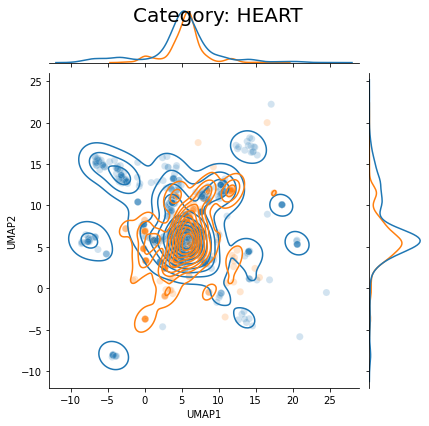

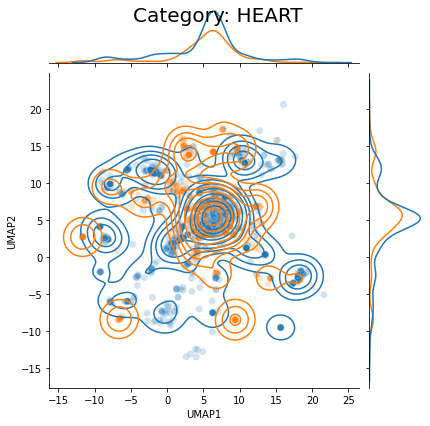

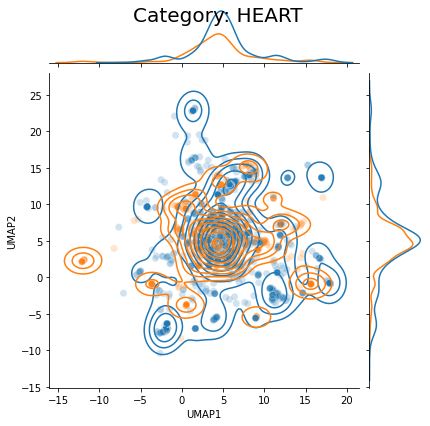

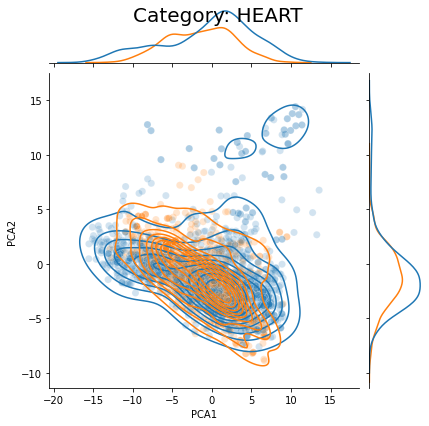

In [ ]:
CAT =  'HEART' # 'INFLAM' # BLOOD, INFLAM, HEART, dataset, draw_hour
PALETTE = None # "Spectral"
alpha = 0.2
csize = 50
kind = 'kde'

q=0.001

q1_05 = embedded_raw_df.UMAP1.quantile(q)
q1_95 = embedded_raw_df.UMAP1.quantile(1-q)
q2_05 = embedded_raw_df.UMAP2.quantile(q)
q2_95 = embedded_raw_df.UMAP2.quantile(1-q)
# generate subplots, 3 cols
g = sns.jointplot(data=embedded_raw_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"), 
              x='UMAP1', y='UMAP2', hue=CAT,palette=PALETTE, legend=False, kind=kind)
sns.scatterplot(data=embedded_raw_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"), 
              x='UMAP1', y='UMAP2', hue=CAT, alpha=alpha, palette=PALETTE, legend=False, s=csize, ax=g.ax_joint)
g.fig.suptitle(f"Category: {CAT}", fontsize=20)
#g.ax_joint.set_xlim(q1_05, q1_95)
#g.ax_joint.set_ylim(q2_05, q2_95)
g.fig.show()

q1_05 = embedded_full_df.UMAP1.quantile(q)
q1_95 = embedded_full_df.UMAP1.quantile(1-q)
q2_05 = embedded_full_df.UMAP2.quantile(q)
q2_95 = embedded_full_df.UMAP2.quantile(1-q)
g = sns.jointplot(data=embedded_full_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"), 
                x='UMAP1', y='UMAP2', hue=CAT, palette=PALETTE, legend=False, kind=kind)
sns.scatterplot(data=embedded_full_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                                & UMAP2>{q1_05} & UMAP2<{q1_95}"),
                x='UMAP1', y='UMAP2', hue=CAT, alpha=alpha, palette=PALETTE, legend=False, s=csize, ax=g.ax_joint)
g.fig.suptitle(f"Category: {CAT}", fontsize=20)
#g.ax_joint.set_xlim(q1_05, q1_95)
#g.ax_joint.set_ylim(q2_05, q2_95)
g.fig.show()

q1_05 = embedded_full_update_df.UMAP1.quantile(q)
q1_95 = embedded_full_update_df.UMAP1.quantile(1-q)
q2_05 = embedded_full_update_df.UMAP2.quantile(q)
q2_95 = embedded_full_update_df.UMAP2.quantile(1-q)
g = sns.jointplot(data=embedded_full_update_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                              & UMAP2>{q1_05} & UMAP2<{q1_95}"),
                x='UMAP1', y='UMAP2', hue=CAT, palette=PALETTE, legend=False, kind=kind)
sns.scatterplot(data=embedded_full_update_df.dropna(subset=[CAT]).query(f"UMAP1>{q1_05} & UMAP1<{q1_95} \
                                                                & UMAP2>{q1_05} & UMAP2<{q1_95}"),
                x='UMAP1', y='UMAP2', hue=CAT, alpha=alpha, palette=PALETTE, legend=False, s=csize, ax=g.ax_joint)
g.fig.suptitle(f"Category: {CAT}", fontsize=20)
#g.ax_joint.set_xlim(q1_05, q1_95)
#g.ax_joint.set_ylim(q2_05, q2_95)
g.fig.show()

q1_05 = embeddedPCA_full_update_df.PCA1.quantile(q)
q1_95 = embeddedPCA_full_update_df.PCA1.quantile(1-q)
q2_05 = embeddedPCA_full_update_df.PCA2.quantile(q)
q2_95 = embeddedPCA_full_update_df.PCA2.quantile(1-q)
g = sns.jointplot(data=embeddedPCA_full_update_df.dropna(subset=[CAT]).query(f"PCA1>{q1_05} & PCA1<{q1_95} \
                                                              & PCA2>{q1_05} & PCA2<{q1_95}"),
                x='PCA1', y='PCA2', hue=CAT, palette=PALETTE, legend=False, kind=kind)
sns.scatterplot(data=embeddedPCA_full_update_df.dropna(subset=[CAT]).query(f"PCA1>{q1_05} & PCA1<{q1_95} \
                                                                & PCA2>{q1_05} & PCA2<{q1_95}"),
                x='PCA1', y='PCA2', hue=CAT, alpha=alpha, palette=PALETTE, legend=False, s=csize, ax=g.ax_joint)
g.fig.suptitle(f"Category: {CAT}", fontsize=20)
#g.ax_joint.set_xlim(q1_05, q1_95)
#g.ax_joint.set_ylim(q2_05, q2_95)
g.fig.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
keep_nans = False
CAT = 'HEART'
if keep_nans:
    df = embedded_full_update_df.fillna('UNK')
else:
    df = embedded_full_update_df[~embedded_full_update_df[CAT].isna()]
df['color'] = LabelEncoder().fit_transform(df[CAT])

import plotly.graph_objects as go

# Create trace
trace = go.Scatter3d(
    x=df.UMAP1,
    y=df.UMAP2,
    z=df.UMAP3,
    mode='markers',
    marker=dict(
        size=3,
        color=df.color,        # set color to the color_var variable
        colorscale='Viridis',   # choose a colorscale
        opacity=0.5
    )
)

# Create layout
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='X axis'),
        yaxis=dict(title='Y axis'),
        zaxis=dict(title='Z axis')
    )
)

# Combine trace and layout and create figure
fig = go.Figure(data=[trace], layout=layout)

# Configure legend
fig.update_layout(
    legend=dict(
        title='Legend Title',
        title_font=dict(size=18),
        font=dict(size=14),
        bgcolor='gray',
        bordercolor='black',
        borderwidth=1
    )
)

# Show plot
fig.show()


C:\Users\bes3\AppData\Local\Temp/ipykernel_10064/3634846959.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

